In [1]:
import pandas as pd
creat = pd.read_csv('../data/intermediate/creatinine_lev.csv')
creat.columns=['patientunitstayid', 'labname', 'labresult', 'labresultoffset', 'qa.aki_offset']
creat.head()

,patientunitstayid,labname,labresult,labresultoffset,qa.aki_offset
0,1736832,creatinine,3.30,6625,9151
1,1736832,creatinine,0.95,-332,9151
2,1736832,creatinine,3.34,7825,9151
3,1736832,creatinine,2.26,1645,9151
4,1736832,creatinine,1.89,925,9151


In [4]:
#creat.set_index('patientunitstayid', inplace=True)
creat.sort_values(by=['patientunitstayid', 'labresultoffset'], inplace=True)
creat.head()

,patientunitstayid,labname,labresult,labresultoffset,qa.aki_offset
7968,142388,creatinine,1.43,-94,1757
7967,142388,creatinine,1.48,1325,1757
7971,142974,creatinine,1.10,-210,2241
7966,142974,creatinine,1.30,175,2241
7969,142974,creatinine,1.20,562,2241


In [60]:
len(creat.patientunitstayid.unique())

2318

In [6]:
creat['next_labresult'] = creat.groupby(['patientunitstayid'])['labresult'].shift(-1)
creat['delta'] = creat['next_labresult'] - creat['labresult']
creat.head()

,patientunitstayid,labname,labresult,labresultoffset,qa.aki_offset,next_labresult,delta
7968,142388,creatinine,1.43,-94,1757,1.48,0.05
7967,142388,creatinine,1.48,1325,1757,NaN,NaN
7971,142974,creatinine,1.10,-210,2241,1.30,0.20
7966,142974,creatinine,1.30,175,2241,1.20,-0.10
7969,142974,creatinine,1.20,562,2241,1.30,0.10


In [8]:
creat['labresultoffset'] = pd.to_timedelta(creat['labresultoffset'], unit='minute')
creat.set_index('labresultoffset', inplace=True)
creat['creat_2day_cum'] = creat.groupby('patientunitstayid')['delta'].apply(lambda x: x.rolling('2d').sum()) 
creat.head()

,patientunitstayid,labname,labresult,qa.aki_offset,next_labresult,delta,creat_2day_cum
labresultoffset,,,,,,,
-1 days +22:26:00,142388,creatinine,1.43,1757,1.48,0.05,0.05
22:05:00,142388,creatinine,1.48,1757,NaN,NaN,0.05
-1 days +20:30:00,142974,creatinine,1.10,2241,1.30,0.20,0.20
02:55:00,142974,creatinine,1.30,2241,1.20,-0.10,0.10
09:22:00,142974,creatinine,1.20,2241,1.30,0.10,0.20


In [104]:
creat.loc[creat['creat_2day_cum'] >= 0.3, 'AKI_reached'] = 1
creat['AKI_reached'].fillna(0, inplace=True)
creat.head()

,patientunitstayid,labname,labresult,qa.aki_offset,next_labresult,delta,creat_2day_cum,AKI_reached,creat_fold_change,creat_7day_inc,AKI_reached_7d
labresultoffset,,,,,,,,,,,
-1 days +22:26:00,142388,creatinine,1.43,1757,1.48,0.05,0.05,0.0,1.034965,1.034965,0.0
22:05:00,142388,creatinine,1.48,1757,NaN,NaN,0.05,0.0,NaN,1.034965,0.0
-1 days +20:30:00,142974,creatinine,1.10,2241,1.30,0.20,0.20,0.0,1.181818,1.181818,0.0
02:55:00,142974,creatinine,1.30,2241,1.20,-0.10,0.10,0.0,0.923077,1.090909,0.0
09:22:00,142974,creatinine,1.20,2241,1.30,0.10,0.20,0.0,1.083333,1.181818,0.0


In [37]:
# diagnosis explained by 0.3mg/mL increase in 48h
exp48 = creat.groupby('patientunitstayid')['AKI_reached'].sum()
exp48.value_counts()
#exp48[exp48>1] = 1
#exp48.sum()/len(exp48)

0.0     798
2.0     349
3.0     347
4.0     210
5.0     150
1.0     118
6.0      95
7.0      64
8.0      46
9.0      35
10.0     28
12.0     22
11.0     21
13.0      9
15.0      7
16.0      4
17.0      4
14.0      3
18.0      2
20.0      2
21.0      1
22.0      1
24.0      1
19.0      1
Name: AKI_reached, dtype: int64

In [26]:
exp48[exp48>1] = 1
exp48.sum()/len(exp48)

0.6557377049180327

## 65% of diagnosis explained by 0.3md/dL increase in 2 days. However, in all cases the criterion for acute kidney injury is reached more than once before the diagnosis. This mean the model could be predicting aki based on creatnine which always comes up as the top feature!

In [20]:
import math
import numpy as np
creat['creat_fold_change'] = creat['next_labresult']/creat['labresult']
creat['creat_7day_inc'] = creat.groupby('patientunitstayid')['creat_fold_change'].apply(lambda x: x.rolling('7d').apply(np.prod))
#rolling(5).apply(np.prod)
creat.head()

,patientunitstayid,labname,labresult,qa.aki_offset,next_labresult,delta,creat_2day_cum,AKI_reached,creat_fold_change,creat_7day_inc
labresultoffset,,,,,,,,,,
-1 days +22:26:00,142388,creatinine,1.43,1757,1.48,0.05,0.05,0.0,1.034965,1.034965
22:05:00,142388,creatinine,1.48,1757,NaN,NaN,0.05,0.0,NaN,1.034965
-1 days +20:30:00,142974,creatinine,1.10,2241,1.30,0.20,0.20,0.0,1.181818,1.181818
02:55:00,142974,creatinine,1.30,2241,1.20,-0.10,0.10,0.0,0.923077,1.090909
09:22:00,142974,creatinine,1.20,2241,1.30,0.10,0.20,0.0,1.083333,1.181818


In [34]:
creat.drop('AKI_reached_7d', axis=1, inplace=True)
creat.loc[creat['creat_7day_inc'] >= 1.5, 'AKI_reached_7d'] = 1
creat['AKI_reached_7d'].fillna(0, inplace=True)
creat.head()

,patientunitstayid,labname,labresult,qa.aki_offset,next_labresult,delta,creat_2day_cum,AKI_reached,creat_fold_change,creat_7day_inc,AKI_reached_7d
labresultoffset,,,,,,,,,,,
-1 days +22:26:00,142388,creatinine,1.43,1757,1.48,0.05,0.05,0.0,1.034965,1.034965,0.0
22:05:00,142388,creatinine,1.48,1757,NaN,NaN,0.05,0.0,NaN,1.034965,0.0
-1 days +20:30:00,142974,creatinine,1.10,2241,1.30,0.20,0.20,0.0,1.181818,1.181818,0.0
02:55:00,142974,creatinine,1.30,2241,1.20,-0.10,0.10,0.0,0.923077,1.090909,0.0
09:22:00,142974,creatinine,1.20,2241,1.30,0.10,0.20,0.0,1.083333,1.181818,0.0


In [36]:
exp7d = creat.groupby('patientunitstayid')['AKI_reached_7d'].sum()
exp7d.value_counts()
#exp7d[exp7d[exp7d1] = 1
#exp48.sum()/len(exp48)

0.0     1257
2.0      239
3.0      187
4.0      148
5.0      110
6.0       80
1.0       55
7.0       53
8.0       52
9.0       29
12.0      26
11.0      17
10.0      17
14.0       9
13.0       9
15.0       7
17.0       6
16.0       4
18.0       2
20.0       2
34.0       1
38.0       1
28.0       1
21.0       1
22.0       1
25.0       1
19.0       1
24.0       1
23.0       1
Name: AKI_reached_7d, dtype: int64

In [42]:
same_pat = pd.concat([exp7d, exp48], axis=1, ignore_index=False)
len(same_pat)

2318

In [41]:
same_pat.dropna(inplace=True)
len(same_pat)

2318

In [45]:
same_pat_both = same_pat[(same_pat['AKI_reached_7d']!=0) & (same_pat['AKI_reached']!=0)]
same_pat_both

,AKI_reached_7d,AKI_reached
patientunitstayid,,
144173,4.0,6.0
144770,7.0,3.0
149913,2.0,3.0
150626,5.0,4.0
153993,8.0,8.0
...,...,...
3350977,3.0,3.0
3351357,5.0,5.0
3351749,2.0,3.0


In [46]:
len(same_pat_both)/len(same_pat)

0.455565142364107

In [48]:
d7_only = same_pat[(same_pat['AKI_reached_7d']!=0) & (same_pat['AKI_reached']==0)]
d7_only

,AKI_reached_7d,AKI_reached
patientunitstayid,,
376983,2.0,0.0
422545,2.0,0.0
3003490,1.0,0.0
3056722,1.0,0.0
3334864,2.0,0.0


In [53]:
len(d7_only)

5

In [51]:
h48_only = same_pat[(same_pat['AKI_reached_7d']==0) & (same_pat['AKI_reached']!=0)]
h48_only

,AKI_reached_7d,AKI_reached
patientunitstayid,,
143466,0.0,3.0
143518,0.0,2.0
145467,0.0,2.0
150577,0.0,3.0
152661,0.0,3.0
...,...,...
3348292,0.0,2.0
3349087,0.0,2.0
3350777,0.0,2.0


In [52]:
len(h48_only)/len(same_pat)

0.2001725625539258

In [112]:
#creat.reset_index(inplace=True)
#first_2d = creat[creat['AKI_reached']==1].groupby('patientunitstayid')['labresultoffset'].first()
first_2d = first_2d/pd.Timedelta('1 minute')
first_2d.head()

patientunitstayid
143466    704.0
143518   -107.0
144173    552.0
144770    742.0
145467    881.0
Name: labresultoffset, dtype: float64

In [113]:
first_7d = creat[creat['AKI_reached_7d']==1].groupby('patientunitstayid')['labresultoffset'].first()
first_7d = first_7d/pd.Timedelta('1 minute')
first_7d.head()

patientunitstayid
144173    1002.0
144770     742.0
149913     160.0
150626   -1499.0
153993   -2423.0
Name: labresultoffset, dtype: float64

In [115]:
aki_offset = creat.groupby('patientunitstayid')['qa.aki_offset'].first()
aki_offset

patientunitstayid
142388     1757
142974     2241
143466     7083
143518     4468
144173     1778
           ... 
3351374    1653
3351749    1665
3352444    2049
3353194    2212
3353197    6586
Name: qa.aki_offset, Length: 2318, dtype: int64

In [146]:
#first_occur_comb = pd.concat([first_2d, first_7d, aki_offset], axis=1, ignore_index=False)
#first_occur_comb.fillna(0, inplace=True)
#first_occur_comb.columns = ['2d_detect', '7d_detect', 'diagnosis']
first_occur_comb = pd.concat([first_occur_comb, urine_6h], axis=1, ignore_index=False)
first_occur_comb.fillna(0, inplace=True)
first_occur_comb

,2d_detect,7d_detect,diagnosis,2d_detect_dif,7d_detect_dif,intakeoutputoffset
patientunitstayid,,,,,,
142388,0.0,0.0,1757,29.283333,29.283333,0.0
142974,0.0,0.0,2241,37.350000,37.350000,0.0
143466,704.0,0.0,7083,106.316667,118.050000,0.0
143518,-107.0,0.0,4468,76.250000,74.466667,0.0
144173,552.0,1002.0,1778,20.433333,12.933333,0.0
...,...,...,...,...,...,...
3351374,0.0,0.0,1653,27.550000,27.550000,647.0
3351749,-110.0,207.0,1665,29.583333,24.300000,0.0
3352444,-1007.0,-1007.0,2049,50.933333,50.933333,0.0


In [150]:
first_occur_comb.loc[first_occur_comb['2d_detect']==0, '2d_detect_dif'] = 0
first_occur_comb.loc[first_occur_comb['7d_detect']==0, '7d_detect_dif'] = 0
first_occur_comb.loc[first_occur_comb['intakeoutputoffset']==0, '6h_detect_dif'] = 0

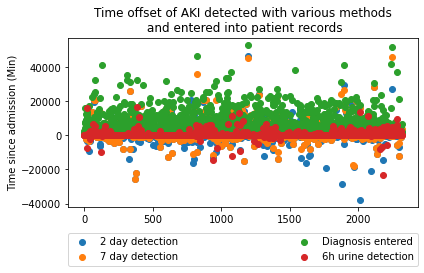

In [172]:
import matplotlib.pyplot as plt
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['2d_detect'], label='2 day detection')
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['7d_detect'], label='7 day detection')
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['diagnosis'], label='Diagnosis entered')
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['intakeoutputoffset'], label='6h urine detection')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
plt.ylabel('Time since admission (Min)')
plt.title('Time offset of AKI detected with various methods\n and entered into patient records')
plt.tight_layout()
plt.savefig('../images/detect_diag_offsets.png')

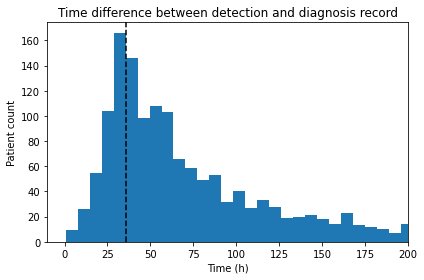

In [174]:
import seaborn as sns
"""
first_occur_comb['2d_detect_dif'] = first_occur_comb['diagnosis']-first_occur_comb['2d_detect']
first_occur_comb['2d_detect_dif']=first_occur_comb['2d_detect_dif']/60
first_occur_comb['7d_detect_dif'] = first_occur_comb['diagnosis']-first_occur_comb['7d_detect']
first_occur_comb['7d_detect_dif']=first_occur_comb['7d_detect_dif']/60
first_occur_comb['6h_detect_dif'] = first_occur_comb['diagnosis']-first_occur_comb['intakeoutputoffset']
first_occur_comb['6h_detect_dif']=first_occur_comb['6h_detect_dif']/60"""
first_occur_comb[first_occur_comb['2d_detect_dif']!=0]['2d_detect_dif'].hist(bins=100)
#first_occur_comb['7d_detect_dif'].plot.density()
#first_occur_comb['6h_detect_dif'].plot.density()
plt.xlim(-10, 200)
plt.axvline(36, ls = '--', c='k')
plt.xlabel('Time (h)')
plt.ylabel('Patient count')
plt.title('Time difference between detection and diagnosis record')
plt.grid(b=None)
plt.tight_layout()
plt.savefig('../images/detect_diag_difdist.png')

## For 34% of results the time differnce between clinical detection and diagnosis being entered is < 8h. But for the rest, there is a long tail of many days. Based on this data I should use the KDIGO definition onset and not diagnosis time.

In [61]:
urine = pd.read_csv('../data/intermediate/urine_out.csv')
urine.columns = ['patientunitstayid', 'intakeoutputoffset', 'cellvaluenumeric', 'celllabel']
urine.head()

,patientunitstayid,intakeoutputoffset,cellvaluenumeric,celllabel
0,150626,-3225,400.0,Urine
1,155653,1386,100.0,Urine
2,157943,14271,92.4,Bodyweight (kg)
3,221736,850,360.0,Urine
4,237769,-6437,500.0,Urine


In [62]:
urine.sort_values(by=['patientunitstayid', 'intakeoutputoffset', 'celllabel'])
urine.head()

,patientunitstayid,intakeoutputoffset,cellvaluenumeric,celllabel
0,150626,-3225,400.0,Urine
1,155653,1386,100.0,Urine
2,157943,14271,92.4,Bodyweight (kg)
3,221736,850,360.0,Urine
4,237769,-6437,500.0,Urine


In [63]:
len(urine.patientunitstayid.unique())

2088

In [65]:
urine.set_index(['patientunitstayid', 'intakeoutputoffset', 'celllabel'], inplace=True)
urine.head()

,,,cellvaluenumeric
patientunitstayid,intakeoutputoffset,celllabel,
150626,-3225,Urine,400.0
155653,1386,Urine,100.0
157943,14271,Bodyweight (kg),92.4
221736,850,Urine,360.0
237769,-6437,Urine,500.0


In [67]:
urine = urine.unstack(level=2)
urine.head()

cellvaluenumeric      
celllabel                             Bodyweight (kg) Urine
patientunitstayid intakeoutputoffset                       
142388            -86                            96.6   NaN
                  -38                            95.9   NaN
                   1462                          99.0   NaN
142974            -233                          117.9   NaN
                  -15                           107.9   NaN

In [71]:
urine.columns = urine.columns.droplevel()
urine.columns = ['Bodyweight (kg)', 'Urine (mL)']
urine.head()

Bodyweight (kg)  Urine (mL)
patientunitstayid intakeoutputoffset                             
142388            -86                            96.6         NaN
                  -38                            95.9         NaN
                   1462                          99.0         NaN
142974            -233                          117.9         NaN
                  -15                           107.9         NaN

In [83]:
urine.reset_index(inplace=True)
urine.head()

,patientunitstayid,intakeoutputoffset,Bodyweight (kg),Urine (mL),ml/kg
0,142388,-86,96.6,NaN,NaN
1,142388,-38,95.9,NaN,NaN
2,142388,1462,99.0,NaN,NaN
3,142974,-233,117.9,NaN,NaN
4,142974,-15,107.9,NaN,NaN


In [87]:
urine['ml/kg/h'] = urine['ml/kg'] / (urine['intakeoutputoffset'].abs()/60)
urine.head()

,patientunitstayid,intakeoutputoffset,Bodyweight (kg),Urine (mL),ml/kg,ml/kg/h
0,142388,-86,96.6,NaN,NaN,NaN
1,142388,-38,95.9,NaN,NaN,NaN
2,142388,1462,99.0,NaN,NaN,NaN
3,142974,-233,117.9,NaN,NaN,NaN
4,142974,-15,107.9,NaN,NaN,NaN


In [88]:
urine['ml/kg'].isna().sum()

56996

In [89]:
urine_nonull = urine.dropna()
urine_nonull['ml/kg'].isna().sum()

0

In [90]:
urine_nonull

,patientunitstayid,intakeoutputoffset,Bodyweight (kg),Urine (mL),ml/kg,ml/kg/h
157,155653,82,86.4,225.0,2.604167,1.905488
163,155653,802,86.4,350.0,4.050926,0.303062
198,157260,-7530,77.6,0.0,0.000000,0.000000
206,157260,-4684,81.3,325.0,3.997540,0.051207
350,157943,15771,92.9,250.0,2.691066,0.010238
...,...,...,...,...,...,...
57834,3350777,1674,104.7,40.0,0.382044,0.013693
57870,3350977,2259,95.9,40.0,0.417101,0.011078
57931,3351133,1694,65.0,75.0,1.153846,0.040868
57984,3351374,647,77.8,50.0,0.642674,0.059599


In [91]:
urine_nonull['intakeoutputoffset'] = pd.to_timedelta(urine_nonull['intakeoutputoffset'], unit='minute')
urine_nonull.set_index('intakeoutputoffset', inplace=True)
urine_nonull['urine_6h_ave'] = urine_nonull.groupby('patientunitstayid')['ml/kg/h'].apply(lambda x: x.rolling('6h').mean()) 
urine_nonull.head()

<ipython-input-91-a1e09bab09ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urine_nonull['intakeoutputoffset'] = pd.to_timedelta(urine_nonull['intakeoutputoffset'], unit='minute')
<ipython-input-91-a1e09bab09ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urine_nonull['urine_6h_ave'] = urine_nonull.groupby('patientunitstayid')['ml/kg/h'].apply(lambda x: x.rolling('6h').mean())


,patientunitstayid,Bodyweight (kg),Urine (mL),ml/kg,ml/kg/h,urine_6h_ave
intakeoutputoffset,,,,,,
0 days 01:22:00,155653,86.4,225.0,2.604167,1.905488,1.905488
0 days 13:22:00,155653,86.4,350.0,4.050926,0.303062,0.303062
-6 days +18:30:00,157260,77.6,0.0,0.000000,0.000000,0.000000
-4 days +17:56:00,157260,81.3,325.0,3.997540,0.051207,0.051207
10 days 22:51:00,157943,92.9,250.0,2.691066,0.010238,0.010238


In [93]:
pd.set_option('mode.chained_assignment', None)
urine_nonull.loc[urine_nonull['urine_6h_ave'] < 0.5, 'AKI_reached_6h'] = 1
urine_nonull['AKI_reached_6h'].fillna(0, inplace=True)
urine_nonull

,patientunitstayid,Bodyweight (kg),Urine (mL),ml/kg,ml/kg/h,urine_6h_ave,AKI_reached_6h
intakeoutputoffset,,,,,,,
0 days 01:22:00,155653,86.4,225.0,2.604167,1.905488,1.905488,0.0
0 days 13:22:00,155653,86.4,350.0,4.050926,0.303062,0.303062,1.0
-6 days +18:30:00,157260,77.6,0.0,0.000000,0.000000,0.000000,1.0
-4 days +17:56:00,157260,81.3,325.0,3.997540,0.051207,0.051207,1.0
10 days 22:51:00,157943,92.9,250.0,2.691066,0.010238,0.010238,1.0
...,...,...,...,...,...,...,...
1 days 03:54:00,3350777,104.7,40.0,0.382044,0.013693,0.013693,1.0
1 days 13:39:00,3350977,95.9,40.0,0.417101,0.011078,0.011078,1.0
1 days 04:14:00,3351133,65.0,75.0,1.153846,0.040868,0.040868,1.0


In [144]:
#urine_nonull.reset_index(inplace=True)
urine_6h = urine_nonull[urine_nonull['AKI_reached_6h']==1].groupby('patientunitstayid')['intakeoutputoffset'].first()
urine_6h = urine_6h/pd.Timedelta('1 minute')
urine_6h

patientunitstayid
155653       802.0
157260     -7530.0
157943     15771.0
173067      2722.0
174390     -2040.0
            ...   
3349975      806.0
3350777     1674.0
3350977     2259.0
3351133     1694.0
3351374      647.0
Name: intakeoutputoffset, Length: 447, dtype: float64

In [94]:
exp6h = urine_nonull.groupby('patientunitstayid')['AKI_reached_6h'].sum()
exp6h.value_counts()

1.0     237
2.0      91
3.0      49
0.0      45
4.0      24
6.0      11
7.0      11
5.0      11
8.0       5
9.0       3
13.0      1
12.0      1
10.0      1
14.0      1
16.0      1
Name: AKI_reached_6h, dtype: int64

In [97]:
same_pat = pd.concat([same_pat, exp6h], axis=1, ignore_index=False)
same_pat

,AKI_reached_7d,AKI_reached,AKI_reached_6h
patientunitstayid,,,
142388,0.0,0.0,NaN
142974,0.0,0.0,NaN
143466,0.0,3.0,NaN
143518,0.0,2.0,NaN
144173,4.0,6.0,NaN
...,...,...,...
3351374,0.0,0.0,1.0
3351749,2.0,3.0,NaN
3352444,2.0,2.0,NaN


In [98]:
no_simp = same_pat[(same_pat['AKI_reached_7d']==0) | (same_pat['AKI_reached_7d'].isna())]
print(len(same_pat))
print(len(no_simp))

2318
1257


In [101]:
no_simp = no_simp[(no_simp['AKI_reached']==0) | (no_simp['AKI_reached'].isna())]
print(len(no_simp))

671


In [102]:
no_simp = no_simp[(no_simp['AKI_reached_6h']==0) | (no_simp['AKI_reached_6h'].isna())]
print(len(no_simp))

671


In [103]:
no_simp

,AKI_reached_7d,AKI_reached,AKI_reached_6h
patientunitstayid,,,
142388,0.0,0.0,NaN
142974,0.0,0.0,NaN
147449,0.0,0.0,NaN
149542,0.0,0.0,NaN
152518,0.0,0.0,NaN
...,...,...,...
3345523,0.0,0.0,NaN
3346657,0.0,0.0,NaN
3349239,0.0,0.0,NaN
